# DLA-34 in Keras with HSwish as option

In [39]:
from keras.layers import Conv2D, BatchNormalization, Input, MaxPool2D, Conv2DTranspose
from keras.activations import relu
from keras.models import Sequential, Model
from keras.layers.merge import add, concatenate
from keras.optimizers import SGD

from keras import backend as K
from keras.layers import Layer
    
import numpy as np

In [2]:
class ReLU(Layer):
    def __init__(self, **kwargs):
        super(ReLU, self).__init__(**kwargs)

    def build(self, input_shape):
        super(ReLU, self).build(input_shape)

    def call(self, x):
        return K.relu(x)

    def compute_output_shape(self, input_shape):
        return input_shape
    
class HSwish(Layer):
    def __init__(self, **kwargs):
        super(HSwish, self).__init__(**kwargs)

    def build(self, input_shape):
        super(HSwish, self).build(input_shape)

    def call(self, x):
        six = K.ones_like(x)*6
        return x* K.minimum(K.relu(x+3),six)/6

    def compute_output_shape(self, input_shape):
        return input_shape

In [3]:
class Tree():
    def __init__(self, name):
        self.root = None
        self.tree1 = None
        self.tree2 = None
        self.level_root = None
        self.root_dim = None
        self.downsample = None
        self.project = None
        self.levels = None
        
        self.name = name
        
    def __print_indent(self, indent, text, end='\n'):
        print( "".join([' ']*indent), end='')
        print(text, end = end)
              
    def print(self, indent = 0):
        self.__print_indent(1 if indent>0 else 0, "[NODE: "+str(self.name), end=' ')
        self.__print_indent(0, "lr:"+str(self.level_root), end=' ')
        self.__print_indent(0, "rdim:"+str(self.root_dim), end=' ')
        self.__print_indent(0, "downs: "+str(self.downsample==None), end=' ')
        self.__print_indent(0, "proj: "+str(self.project==None), end=' ')
        self.__print_indent(0, "levs: "+str(self.levels), end=']\n')
        
        if self.root is None:
              self.__print_indent(indent+2, "R1> None")
        else:
              self.__print_indent(indent+2, "R1> conv,bn,act ")
              
        if isinstance(self.tree1,Tree):
            self.__print_indent(indent+2, "T1>", end='')
            self.tree1.print(indent=indent+4)
        elif self.tree1 is not None:
            self.__print_indent(indent+2, "T1> conv,bn")

        if isinstance(self.tree2,Tree):
            self.__print_indent(indent+2, "T2>", end='')
            self.tree2.print(indent=indent+4)
        elif self.tree2 is not None:
            self.__print_indent(indent+2, "T2> conv,bn")

In [4]:
class DlaKeras():
    def __init__(self,  
                 levels=[1, 1, 1, 2, 2, 1],
                 planes=[16, 32, 64, 128, 256, 512],
                 activation_function="relu"):
        self.norm_axis = -1
        self.activation_function = activation_function
        
        self.base_layer = self._make_simple_block(planes[0], kernel_size=7)
        self.level0 = self._make_conv_level(planes[0], levels[0], stride=1)
        self.level1 = self._make_conv_level(planes[1], levels[1], stride=2)
        
        self.level2 = self._make_tree("L2_", levels[2], planes[1], planes[2], level_root=False)
        self.level3 = self._make_tree("L3_",levels[3], planes[2], planes[3])
        self.level4 = self._make_tree("L4_",levels[4], planes[3], planes[4])
        self.level5 = self._make_tree("L5_",levels[5], planes[4], planes[5])
        
    def _make_tree(self, name, levels, in_planes, planes, stride=2, level_root=True, root_dim=0):
        result = Tree(name)
        
        if root_dim == 0:
            root_dim = 2 * planes
        if level_root:
            root_dim += in_planes
        
        if levels==1:
            result.tree1 = self._make_basic_block(planes, stride)
            result.tree2 = self._make_basic_block(planes, 1)
        else:
            result.tree1 = self._make_tree(name+"1",levels-1, in_planes, planes, stride=stride)
            result.tree2 = self._make_tree(name+"2",levels-1, planes, planes, stride=1, root_dim=root_dim + planes)
            
        if levels == 1:
            result.root = self._make_root(root_dim, planes)   # TODO minor: remove root_dim ?
        
        result.level_root = level_root
        result.root_dim = root_dim
        result.levels = levels
        if stride > 1:
            result.downsample = MaxPool2D(pool_size=(stride, stride), strides=(stride, stride), padding = 'same')
            
        if in_planes != planes:
            result.project = []
            result.project.append(Conv2D(filters=planes, kernel_size=1, padding='same', strides=(1,1), use_bias=False))
            result.project.append(BatchNormalization(axis=self.norm_axis))    

        return result

    def _make_root(self, in_planes, planes):
        return self._make_simple_block(planes)
    
    def _make_basic_block(self, planes, stride=1):
        layers=[]
        
        conv1 = Conv2D(filters=planes, kernel_size=3, padding='same', strides=(stride,stride), use_bias=False)
        bn1 = BatchNormalization(axis=self.norm_axis)
        if self.activation_function == "hswish":
            activation = HSwish()
        else:
            activation = ReLU()
        conv2 = Conv2D(filters=planes, kernel_size=3, padding='same', strides=(1,1), use_bias=False)
        bn2 = BatchNormalization(axis=self.norm_axis)
        
        layers = [conv1,bn1,activation, conv2, bn2]
        return layers
    
    def _make_simple_block(self, planes, kernel_size=3, stride = 1):
        
        conv = Conv2D(filters=planes, kernel_size=kernel_size, padding='same', strides=(stride,stride), use_bias=False)
        bn = BatchNormalization(axis=self.norm_axis)
        if self.activation_function == "hswish":
            activation = HSwish()
        else:
            activation = ReLU()
        
        layers = [conv,bn,activation]
        
        return layers
    
    def _make_conv_level(self, planes, levels, stride = 1):
        layers = []
        for i in range(levels):
            layers.extend(self._make_simple_block(planes, stride = stride))
        return layers
            
    def _build_list(self, x, layers):
        for l in layers:
            x = l(x)
        return x
    
    def _build_root(self, root, *x):
        x = list(x)
        conv = root[0]
        bn = root[1]
        act = root[2]
        
        x = concatenate(x, axis = self.norm_axis)
        x = conv(x)
        x = bn(x)
        x = act(x)

        return x
    
    def _build_tree(self,x, tree, children=None, residual=None):
        if not isinstance(tree, Tree):
            return self._build_list(x,tree)
        
        
        children = [] if children is None else children
        bottom = tree.downsample(x) if tree.downsample else x
        residual = self._build_list(bottom,tree.project) if tree.project else bottom
        
        if tree.level_root:
            children.append(bottom)

        x1 = self._build_tree(x, tree.tree1, residual=residual)

        if tree.levels == 1:
            x2 = self._build_tree(x1,tree.tree2)
            x = self._build_root(tree.root, x2, x1, *children)
        else:
            children.append(x1)
            x = self._build_tree(x1, tree.tree2, children=children)
        return x
        
    def build(self, inputs):
        x = self._build_list(inputs, self.base_layer)
        l0 = self._build_list(x, self.level0)
        l1 = self._build_list(l0, self.level1)
        l2 = self._build_tree(l1, self.level2)
        l3 = self._build_tree(l2, self.level3)
        l4 = self._build_tree(l3, self.level4)
        l5 = self._build_tree(l4, self.level5)
        return [l0,l1,l2,l3,l4,l5]

In [41]:
class Identity():
    def __init__(self):
        pass
    
    def build(self, x):
        return x
    
    def __call__(self,x):
        return self.build(x)

In [54]:
class IdaUp():
    def __init__(self, node_kernel, out_dim, planes, up_factors):
        self.planes = planes
        self.projs = {}
        self.ups = {}
        self.nodes = {}
        
        for i, c in enumerate(planes):
            if c == out_dim:
                proj = [Identity()]
            else:
                proj = [Conv2D(filters=out_dim, kernel_size=1, padding='same', strides=(1,1), use_bias=False),
                        BatchNormalization(axis=-1),
                        ReLU()]
            f = int(up_factors[i])
            if f == 1:
                up = Identity()
            else:
                up = Conv2DTranspose(out_dim, kernel_size= f * 2, strides=f, padding="same", use_bias=False)
                
            self.projs[i] = proj
            self.ups[i] = up
            
        for i in range(1, len(planes)):
            node = [Conv2D(out_dim, kernel_size=node_kernel, strides=1,padding="same", use_bias=False),
                    BatchNormalization(axis=-1),
                    ReLU()]
            self.nodes[i] = node
            
    def _build_list(self, x, layers):
        for l in layers:
            x = l(x)
        return x
    
    def build(self, layers):
        assert(len(self.planes) == len(layers))
        layers = list(layers)
        for i, l in enumerate(layers):
            upsample = self.ups[i]
            project = self.projs[i]
            
            layers[i] = upsample(self._build_list(l, project))
            
        x = layers[0]
        y = []
        for i in range(1, len(layers)):
            node = self.nodes[i]
            concatenated = concatenate([x, layers[i]], axis=-1)
            x = self._build_list(concatenated, node)
            y.append(x)
        return x, y

In [55]:
class DlaUp():
    def __init__(self, planes, scales):
        self.planes = planes
        self.scales = np.array(scales, dtype=int)
        self.in_planes = list(planes)
        self.idas ={}
        
        for i in range(len(self.planes) - 1):
            j = -i - 2
            self.idas[i] = IdaUp(3, self.planes[j], self.in_planes[j:], self.scales[j:] // self.scales[j])
            self.scales[j + 1:] = self.scales[j]
            self.in_planes[j + 1:] = [self.planes[j] for _ in self.planes[j + 1:]]
    
    def build(self, layers):
        layers = list(layers)
        assert len(layers) > 1
        for i in range(len(layers) - 1):
            ida = self.idas[i]
            x, y = ida.build(layers[-i - 2:])
            layers[-i - 1:] = y
        return x

In [56]:
class DlaSeg():
    def __init__(self, down_ratio=4, 
                 head_conv=256,
                 input_shape = (512,512,3),  
                 levels=[1, 1, 1, 2, 2, 1],
                 planes=[16, 32, 64, 128, 256, 512],
                 activation_function="relu"):
        # Params
        assert down_ratio in [2, 4, 8, 16]
        self.input = Input(shape = input_shape)
        self.base = DlaKeras(levels=levels, planes=planes, activation_function=activation_function)
        self.heads = heads={'hm': 1, 'wh': 2}
        
        self.first_level = int(np.log2(down_ratio))
        scales = [2 ** i for i in range(len(planes[self.first_level:]))]
        self.planes = planes
        
        # Up
        self.dla_up = DlaUp(planes[self.first_level:], scales=scales)
        
        # Hed
        self.head_layers = {}
        self.head_conv = head_conv
        for head in heads:
            self.head_layers[head] = self.add_head(head)
            
    def add_head(self, head):
        layers = []
        classes = self.heads[head]
        if self.head_conv > 0:
            layers.append(Conv2D(self.head_conv, kernel_size=(3,3), padding="same", use_bias=True))
            layers.append(ReLU()),
            
        layers.append(Conv2D(classes, kernel_size=(1,1), strides=(1,1), padding='same', use_bias=True ))

        return layers
    
    def _build_list(self, x, layers):
        for l in layers:
            x = l(x)
        return x
    
    def build(self):
        inputs = self.input
        levels = self.base.build(inputs)
        x = self.dla_up.build(levels[self.first_level:])
            
        outputs = []
        for head in self.head_layers:
            outputs.append(self._build_list(x, self.head_layers[head]))
        return Model(inputs = inputs, outputs=outputs)     

# Testing model creation

In [57]:
m = DlaSeg().build()

dummy = np.zeros((1,512,512,3), dtype=float)
dummy_result = m.predict(dummy)
dummy_hm, dummy_wh = dummy_result


print("Output shape calculated:", dummy_hm.shape, dummy_wh.shape)

Output shape calculated: (1, 128, 128, 1) (1, 128, 128, 2)


# Dummy train: does it train at all ?

In [60]:
def dummy_train(model:Model,n=20, epochs=10):
    rand = np.random.rand(1,512,512,1)
    dummy_inputs = np.repeat(np.repeat(rand, n, axis=0),3,axis=-1)
    dummy_outputs_hm = np.zeros((n,dummy_hm.shape[1],dummy_hm.shape[2],dummy_hm.shape[3]))
    dummy_outputs_wh = np.zeros((n,dummy_wh.shape[1],dummy_wh.shape[2],dummy_wh.shape[3]))
    return model.fit(dummy_inputs, [dummy_outputs_hm, dummy_outputs_wh], batch_size=4, epochs=epochs)
    
print("Training:")
m = DlaSeg().build()
optimizer = SGD(lr=0.1)
m.compile(optimizer=optimizer, loss='mse')
dummy_result = dummy_train(m)

Training:
Epoch 1/10
20/20 [==============================] - 45s - loss: 9.7498 - conv2d_1010_loss: 7.2756 - conv2d_1012_loss: 2.4742    
Epoch 2/10
20/20 [==============================] - 44s - loss: 0.0682 - conv2d_1010_loss: 0.0251 - conv2d_1012_loss: 0.0431    
Epoch 3/10
20/20 [==============================] - 44s - loss: 0.0148 - conv2d_1010_loss: 0.0027 - conv2d_1012_loss: 0.0121    
Epoch 4/10
20/20 [==============================] - 44s - loss: 0.0047 - conv2d_1010_loss: 2.9960e-04 - conv2d_1012_loss: 0.0044    
Epoch 5/10
20/20 [==============================] - 44s - loss: 0.0021 - conv2d_1010_loss: 4.5553e-05 - conv2d_1012_loss: 0.0021    
Epoch 6/10
20/20 [==============================] - 44s - loss: 0.0013 - conv2d_1010_loss: 1.8105e-05 - conv2d_1012_loss: 0.0013    
Epoch 7/10
20/20 [==============================] - 44s - loss: 0.0010 - conv2d_1010_loss: 1.4885e-05 - conv2d_1012_loss: 0.0010    
Epoch 8/10
20/20 [==============================] - 44s - loss: 9.0048e

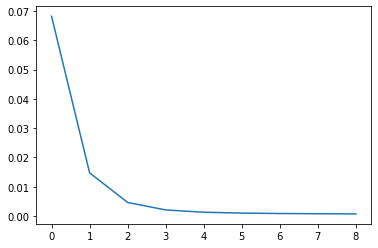

In [72]:
#import matplotlib.pyplot as plt
#plt.plot(dummy_result.history['loss'][1:])